<h1> Nombre: Matías</h1>
<h1> Apellido: Duhalde</h1>
<h1> Número de alumno: 18639496</h1>

# Problema de Regresión

# Pregunta 1

**Nota para el corrector**: Cambié un poco el "orden" de los pasos propuestos en la pregunta 1 y la 2. Hice el preprocesamiento de los datos en la parte 1, sin embargo, esto se pedía para la parte 2. Lo hice así porque me hacía mucho más sentido realizar este preprocesamiento ANTES de formar la matriz de características, debido a que de igual manera tendría que volver a reformularla después de hacer el preprocesamiento. En la issue [#197](https://github.com/UC-IIC2613/Syllabus/issues/197) se comenta que no hay problema en reordenar estas partes.

## Cargar Datos

In [83]:
# Imports para el análisis de datos
import pandas as pd
import numpy as np

# Se define el dataframe principal
diamonds_df = pd.read_csv('./diamonds.csv', index_col=0)

# Se muestra un resumen del dataframe
diamonds_df.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z,Usage
Unnamed: 0,,,,,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,ToV
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,Test
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,ToV
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,ToV
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,ToV


## Análisis de los datos

Se propone la siguiente estrategia para preprocesar los datos:
- Reconocer posibles problemas en las filas, como por ejemplo, datos donde hayan valores nulos, o valores que no hagan mucho sentido
- Revisar la correlación que tienen los datos entre sí para poder determinar los datos más importantes para el precio, y modificarlos acorde a eso
- Convertir los datos de texto (strings) a valores numéricos
- Estandarizar/normalizar los datos

In [84]:
# Revisión general de las características del dataframe

print("-"*40, "SHAPE", "-"*40)
print(diamonds_df.shape)
print("-"*40, "INFO", "-"*40)
print(diamonds_df.info())
print("-"*40, "DESCRIBE", "-"*40)
print(diamonds_df.describe())
print("-"*40, "NULL VALUES", "-"*40)
print(diamonds_df.isnull().sum())
print("-"*40, "LABEL COLUMNS VALUE_COUNTS", "-"*40)
print(diamonds_df['cut'].value_counts())
print(diamonds_df['color'].value_counts())
print(diamonds_df['clarity'].value_counts())
print(diamonds_df['Usage'].value_counts())

---------------------------------------- SHAPE ----------------------------------------
(53940, 11)
---------------------------------------- INFO ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
 10  Usage    53940 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 4.9+ MB
None
---------------------------------------- DESCRIBE ----------------------------------------
              carat         depth         table     

A partir del resumen anterior, se reconoce que existen filas donde los valores de `x`, `y`, o `z` son 0 (ver min de analisis anterior), lo cual no hace sentido, debido a que estos valores representan una dimensión de un objeto tridimensional, la cual físicamente no puede tener valor 0.

A continuación, se muestran las filas donde `x`, `y`, o `z` son 0.

Se decide dropear estas filas, debido a que son pocas y no se perdería mayor información en beneficio a la distribución de los datos.

In [85]:
diamonds_df.loc[(diamonds_df['x'] == 0) | (diamonds_df['y'] == 0) | (diamonds_df['z'] == 0)]

diamonds_df = diamonds_df[diamonds_df['x'] != 0]
diamonds_df = diamonds_df[diamonds_df['y'] != 0]
diamonds_df = diamonds_df[diamonds_df['z'] != 0]

diamonds_df.shape

(53920, 11)

A continuación, se analiza la correlación de los datos numéricos.

Observaciones:
- x, y, z están muy relacionadas entre sí
- x, y, z están muy relacionados con el carat
- carat es el atributo más relacionado con el precio (x, y, z lo siguen de cerca)
- depth y table no están muy relacionadas al precio (pero se puede apreciar que depth está ligeramente relacionada inversamente)
- x, y, z están relacionados en de forma mas o menos parecida al resto de todos los datos

In [86]:
diamonds_df.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028259,0.181646,0.921592,0.977779,0.953991,0.961048
depth,0.028259,1.000000,-0.295733,-0.010729,-0.025017,-0.029069,0.095023
table,0.181646,-0.295733,1.000000,0.127245,0.196097,0.184493,0.152483
price,0.921592,-0.010729,0.127245,1.000000,0.887231,0.867864,0.868206
x,0.977779,-0.025017,0.196097,0.887231,1.000000,0.974918,0.975435
y,0.953991,-0.029069,0.184493,0.867864,0.974918,1.000000,0.956744
z,0.961048,0.095023,0.152483,0.868206,0.975435,0.956744,1.000000


A continuación, se estudia la relación entre los datos discretos y el precio

<AxesSubplot:title={'center':'price'}, xlabel='cut'>

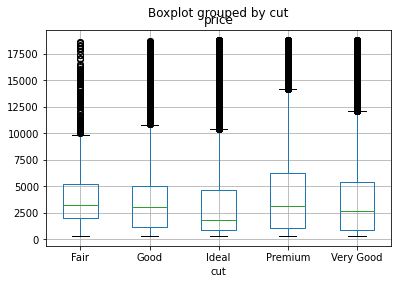

In [87]:
diamonds_df.boxplot(column="price", by='cut')

<AxesSubplot:title={'center':'price'}, xlabel='color'>

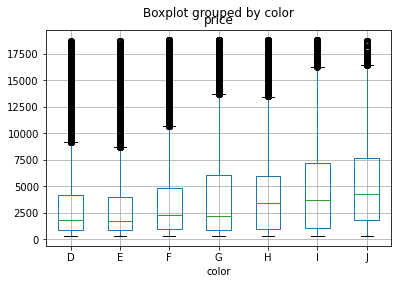

In [88]:
diamonds_df.boxplot(column="price", by='color')

<AxesSubplot:title={'center':'price'}, xlabel='clarity'>

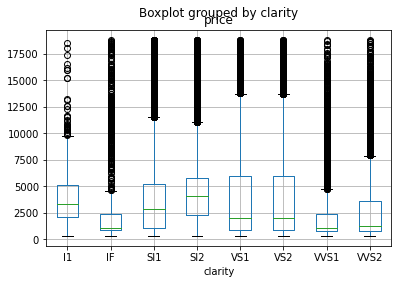

In [89]:
diamonds_df.boxplot(column="price", by='clarity')

De acuerdo a Wikipedia, los órdenes de calidad serían los siguientes (de más calidad a menos calidad):

- **Cut** : Ideal - Premium - Very good - Good - Fair
- **Color** : D - E - F - G - H - I - J
- **Clarity** : IF - VVS1 - VVS2 - VS1 - VS2 - SI1 - SI2 - I1

Fuentes:
- https://en.wikipedia.org/wiki/Diamond_cut
- https://en.wikipedia.org/wiki/Diamond_color
- https://en.wikipedia.org/wiki/Diamond_clarity


Se puede notar que no existe una relación directa en el dataset que estamos usando entre la calidad y el precio alto. De hecho, en los diagramas de caja se puede apreciar un efecto casi contrario. Esto es explicable porque generalmente los diamantes de "mejor calidad" (mejor color, corte, y claridad) tienden a ser más pequeño, y el factor que más influye en el precio final del diamante es el carat (peso). Diamantes grandes tienden a tener más imperfecciones que reducen su calidad, pero compensan en el precio por su alto carat.

Dado lo anterior, se usa la estrategia *One-Hot Encoding* para trabajar los valores no numéricos.


In [90]:
new_diamonds_df = pd.get_dummies(diamonds_df, columns=['cut', 'clarity', 'color'])
new_diamonds_df.head(5)

,carat,depth,table,price,x,y,z,Usage,cut_Fair,cut_Good,...,clarity_VS2,clarity_VVS1,clarity_VVS2,color_D,color_E,color_F,color_G,color_H,color_I,color_J
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,0.23,61.5,55.0,326,3.95,3.98,2.43,ToV,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.21,59.8,61.0,326,3.89,3.84,2.31,Test,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.23,56.9,65.0,327,4.05,4.07,2.31,ToV,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.29,62.4,58.0,334,4.20,4.23,2.63,ToV,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0.31,63.3,58.0,335,4.34,4.35,2.75,ToV,0,1,...,0,0,0,0,0,0,0,0,0,1


También, sabemos que tanto depth como table corresponden a un porcentaje, por lo que podemos normalizar las características a valores entre 0 y 1

In [91]:
new_diamonds_df.depth = new_diamonds_df.depth / 100
new_diamonds_df.table = new_diamonds_df.table / 100

In [92]:
new_diamonds_df.head(5)

,carat,depth,table,price,x,y,z,Usage,cut_Fair,cut_Good,...,clarity_VS2,clarity_VVS1,clarity_VVS2,color_D,color_E,color_F,color_G,color_H,color_I,color_J
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,0.23,0.615,0.55,326,3.95,3.98,2.43,ToV,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.21,0.598,0.61,326,3.89,3.84,2.31,Test,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.23,0.569,0.65,327,4.05,4.07,2.31,ToV,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.29,0.624,0.58,334,4.20,4.23,2.63,ToV,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0.31,0.633,0.58,335,4.34,4.35,2.75,ToV,0,1,...,0,0,0,0,0,0,0,0,0,1


In [93]:
# Resetear index
new_diamonds_df = new_diamonds_df.reset_index().drop('Unnamed: 0', axis=1)

A continuación, se construye la matriz de características

In [94]:
characteristics = new_diamonds_df.drop(['Usage', 'price'], axis=1).to_numpy()

new_dataframe = pd.DataFrame()
new_dataframe['X'] = [*characteristics]
new_dataframe['y'] = new_diamonds_df['price']
new_dataframe['Usage'] = new_diamonds_df['Usage']

new_dataframe.head(5)


,X,y,Usage
0,"[0.23, 0.615, 0.55, 3.95, 3.98, 2.43, 0.0, 0.0...",326,ToV
1,"[0.21, 0.598, 0.61, 3.89, 3.84, 2.31, 0.0, 0.0...",326,Test
2,"[0.23, 0.569, 0.65, 4.05, 4.07, 2.31, 0.0, 1.0...",327,ToV
3,"[0.29, 0.624, 0.58, 4.2, 4.23, 2.63, 0.0, 0.0,...",334,ToV
4,"[0.31, 0.633, 0.58, 4.34, 4.35, 2.75, 0.0, 1.0...",335,ToV


Luego, se separa el set de test del resto

In [95]:
df_test = new_dataframe[new_dataframe['Usage'] == 'Test']
df_tov = new_dataframe[new_dataframe['Usage'] == 'ToV']

In [96]:
X_test = np.stack(df_test['X'].to_numpy())
y_test = df_test['y'].to_numpy()

X_tov = np.stack(df_tov['X'].to_numpy())
y_tov = df_tov['y'].to_numpy()


### Formas de los sets

In [97]:
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)
print("X_tov shape", X_tov.shape)
print("y_tov shape", y_tov.shape)

X_test shape (5349, 26)
y_test shape (5349,)
X_tov shape (48571, 26)
y_tov shape (48571,)


# Pregunta 2

**Nota para el corrector**: tal como se especificó antes, el preprocesamiento se encuentra en la Parte 1.

Además, para mi implementación utilizaré `keras`, por lo que según el enunciado se debe omitir el paso de dividir **ToV** en sets de train y de validación. Sin embargo, debe especificarse el split del set en la etapa de training.

Para esto, elegí un valor de $80\%$ para el set de train, y el $20\%$ restante para el set de validación.

Para decidir este valor, me basé en las cantidades que tiene cada set, lo visto en clases, y el análisis de la tarea pasada. El set de test predefinido tiene un largo de aproximadamente el $10\%$, por lo que el resto de los datos a dividir correspondería al $90\%$. El total de datos es de $53920$, lo cual es considerablemente grande, por lo que se puede usar un porcentaje más pequeño, dejando más datos para el set de entrenamiento, y al mismo tiempo sin afectar la muestra del set de validación. Así, decidí usar una proporción $89\%-11\%$ para el set de train y validación, respectivamente. Así, en total, quedaría aproximadamente las proporciones en 80-10-10, considerando también el set de test.

In [98]:
print("Tamaño total", len(new_dataframe))
print("Tamaño set de test", len(y_test), f'({len(y_test)/len(new_dataframe)*100})')
print("Tamaño set de train", round(len(y_tov)*0.89), f'({len(y_tov)*0.89/len(new_dataframe)*100})')
print("Tamaño set de validación",round(len(y_tov)*0.11), f'({len(y_tov)*0.11/len(new_dataframe)*100})')

Tamaño total 53920
Tamaño set de test 5349 (9.920252225519288)
Tamaño set de train 43228 (80.17097551928784)
Tamaño set de validación 5343 (9.90877225519288)


# Pregunta 3

## Imports

In [99]:
# Imports
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

## Definitions

In [100]:
def create_model_from_tuple(tup, input_shape, activation):
    initial_layer_n, hidden_layer_n = tup
    model = Sequential()
    initial_layer = Dense(initial_layer_n, input_shape=input_shape, activation=activation)
    hidden_layer = Dense(hidden_layer_n, activation=activation)
    output_layer = Dense(1)
    model.add(initial_layer)
    model.add(hidden_layer)
    model.add(output_layer)
    return model


In [101]:
# Constants
input_shape = (X_tov.shape[1],)

tuples = [(10,10), (2, 2), (20, 20), (2, 20), (20, 2), (5, 8)]
activation_functions = ['relu', 'tanh', 'sigmoid']
estimators = ['mse', 'mae']


## Create models

In [102]:
# Create models
models = {}

for est in estimators:
    for act in activation_functions:
        for tup in tuples:
            new_model = create_model_from_tuple(tup, input_shape, act)
            new_model.compile(loss='mse', optimizer='rmsprop', metrics=est)
            models[(est, act, tup)] = (new_model)


## Fit models

In [103]:
# Fit models
number_of_epochs = 50

histories = {}

for model in models:
    print(f'Training {model} model')
    current_model = models[model]
    history = current_model.fit(X_tov, y_tov, epochs=number_of_epochs, batch_size=32, verbose=0, validation_split=0.11)
    histories[model] = history

Training ('mse', 'relu', (10, 10)) model
Training ('mse', 'relu', (2, 2)) model
Training ('mse', 'relu', (20, 20)) model
Training ('mse', 'relu', (2, 20)) model
Training ('mse', 'relu', (20, 2)) model
Training ('mse', 'relu', (5, 8)) model
Training ('mse', 'tanh', (10, 10)) model
Training ('mse', 'tanh', (2, 2)) model
Training ('mse', 'tanh', (20, 20)) model
Training ('mse', 'tanh', (2, 20)) model
Training ('mse', 'tanh', (20, 2)) model
Training ('mse', 'tanh', (5, 8)) model
Training ('mse', 'sigmoid', (10, 10)) model
Training ('mse', 'sigmoid', (2, 2)) model
Training ('mse', 'sigmoid', (20, 20)) model
Training ('mse', 'sigmoid', (2, 20)) model
Training ('mse', 'sigmoid', (20, 2)) model
Training ('mse', 'sigmoid', (5, 8)) model
Training ('mae', 'relu', (10, 10)) model
Training ('mae', 'relu', (2, 2)) model
Training ('mae', 'relu', (20, 20)) model
Training ('mae', 'relu', (2, 20)) model
Training ('mae', 'relu', (20, 2)) model
Training ('mae', 'relu', (5, 8)) model
Training ('mae', 'tanh

## Persist models

In [104]:
import pickle
# Save trained models
for model in models:
    models[model].save(f'models/p3/{model}')

histories_dict = {model : histories[model].history for model in histories}

# Save history
with open('models/p3/history', 'wb') as history_file:
    pickle.dump(histories_dict, history_file)

INFO:tensorflow:Assets written to: models/p3/('mse', 'relu', (10, 10))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'relu', (2, 2))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'relu', (20, 20))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'relu', (2, 20))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'relu', (20, 2))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'relu', (5, 8))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'tanh', (10, 10))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'tanh', (2, 2))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'tanh', (20, 20))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'tanh', (2, 20))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'tanh', (20, 2))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'tanh', (5, 8))/assets
INFO:tensorflow:Assets written to: models/p3/('mse', 'sigmoid', (10, 10))/as

In [107]:
# Load models
models = {}

for est in estimators:
    for act in activation_functions:
        for tup in tuples:
            new_model = keras.models.load_model(f'models/p3/{(est, act, tup)}')
            models[(est, act, tup)] = (new_model)

histories_dict = {}

# Load history
with open('models/p3/history', 'rb') as history_file:
    histories_dict = pickle.load(history_file)

## Test models

In [108]:
results = {}

for model in models:
    print(f'Evaluating {model}')
    results[model] = models[model].evaluate(X_test, y_test, verbose=1)

Evaluating ('mse', 'relu', (10, 10))
168/168 [==============================] - 0s 845us/step - loss: 1368568.7500 - mse: 1368568.7500
Evaluating ('mse', 'relu', (2, 2))
168/168 [==============================] - 0s 662us/step - loss: 1133646.8750 - mse: 1133646.8750
Evaluating ('mse', 'relu', (20, 20))
168/168 [==============================] - 0s 692us/step - loss: 544730.1250 - mse: 544730.1250
Evaluating ('mse', 'relu', (2, 20))
168/168 [==============================] - 0s 679us/step - loss: 799886.3125 - mse: 799886.3125
Evaluating ('mse', 'relu', (20, 2))
168/168 [==============================] - 0s 650us/step - loss: 1471016.8750 - mse: 1471016.8750
Evaluating ('mse', 'relu', (5, 8))
168/168 [==============================] - 0s 652us/step - loss: 497218.4688 - mse: 497218.4688
Evaluating ('mse', 'tanh', (10, 10))
168/168 [==============================] - 0s 749us/step - loss: 26024458.0000 - mse: 26024458.0000
Evaluating ('mse', 'tanh', (2, 2))
168/168 [=====================

A partir del testeo anterior después del entrenamiento, en el cual se usaron batches de 32 de largo y 50 epochs, se pudieron obtener los siguientes resultados, resumidos en dos tablas (una para cada métrica).

*Nota: analicé 6 pares de valores para cantidades de neuronas en lugar de los 5 pedidos, para mayor variedad *

### MSE

| tuple \ activation |         relu |          tanh |       sigmoid |
|--------------------|-------------:|--------------:|--------------:|
| (10, 10)           | 1368568.7500 | 26024458.0000 | 26041524.0000 |
| (2, 2)             | 1133646.8750 | 29675746.0000 | 29686800.0000 |
| (20, 20)           | 544730.1250  | 22291518.0000 | 22321404.0000 |
| (2, 20)            | 799886.3125  | 22296238.0000 | 22310412.0000 |
| (20, 2)            | 1471016.8750 | 29682692.0000 | 29674904.0000 |
| (5, 8)             | 497218.4688  | 26884736.0000 | 26904930.0000 |

### MAE

| tuple \ activation |      relu |      tanh |   sigmoid |
|--------------------|----------:|----------:|----------:|
| (10, 10)           |  381.7404 | 3214.3271 | 3215.8232 |
| (2, 2)             |  794.9835 | 3702.7522 | 3704.9082 |
| (20, 20)           |  373.2545 | 2918.8359 | 2919.7307 |
| (2, 20)            | 3080.9875 | 2918.7505 | 2919.7117 |
| (20, 2)            | 3836.9119 | 3701.8472 | 3702.9404 |
| (5, 8)             |  408.7223 | 3318.0598 | 3319.4309 |


A partir de las tablas, se puede ver que la función de activación `relu` dio los mejores resultados consistentemente en las mediciones. Además, las tuplas que mejores resultados dieron fueron la `(5, 8)` para la métrica MSE (que significa 5 neuronas en la capa de input, y 8 en la oculta), y `(20, 20)` para la métrica MAE. Se logró obtener varios modelos con valores para MAE inferiores a 800, según lo pedido en el enunciado.

El resto de las funciones de activación, mantuvieron valores relativamente altos para ambas métricas, manteniéndose en el orden de los 22-30 M para MSE, y 3200-4000 para MAE.


## Gráficos de evolución de las métricas

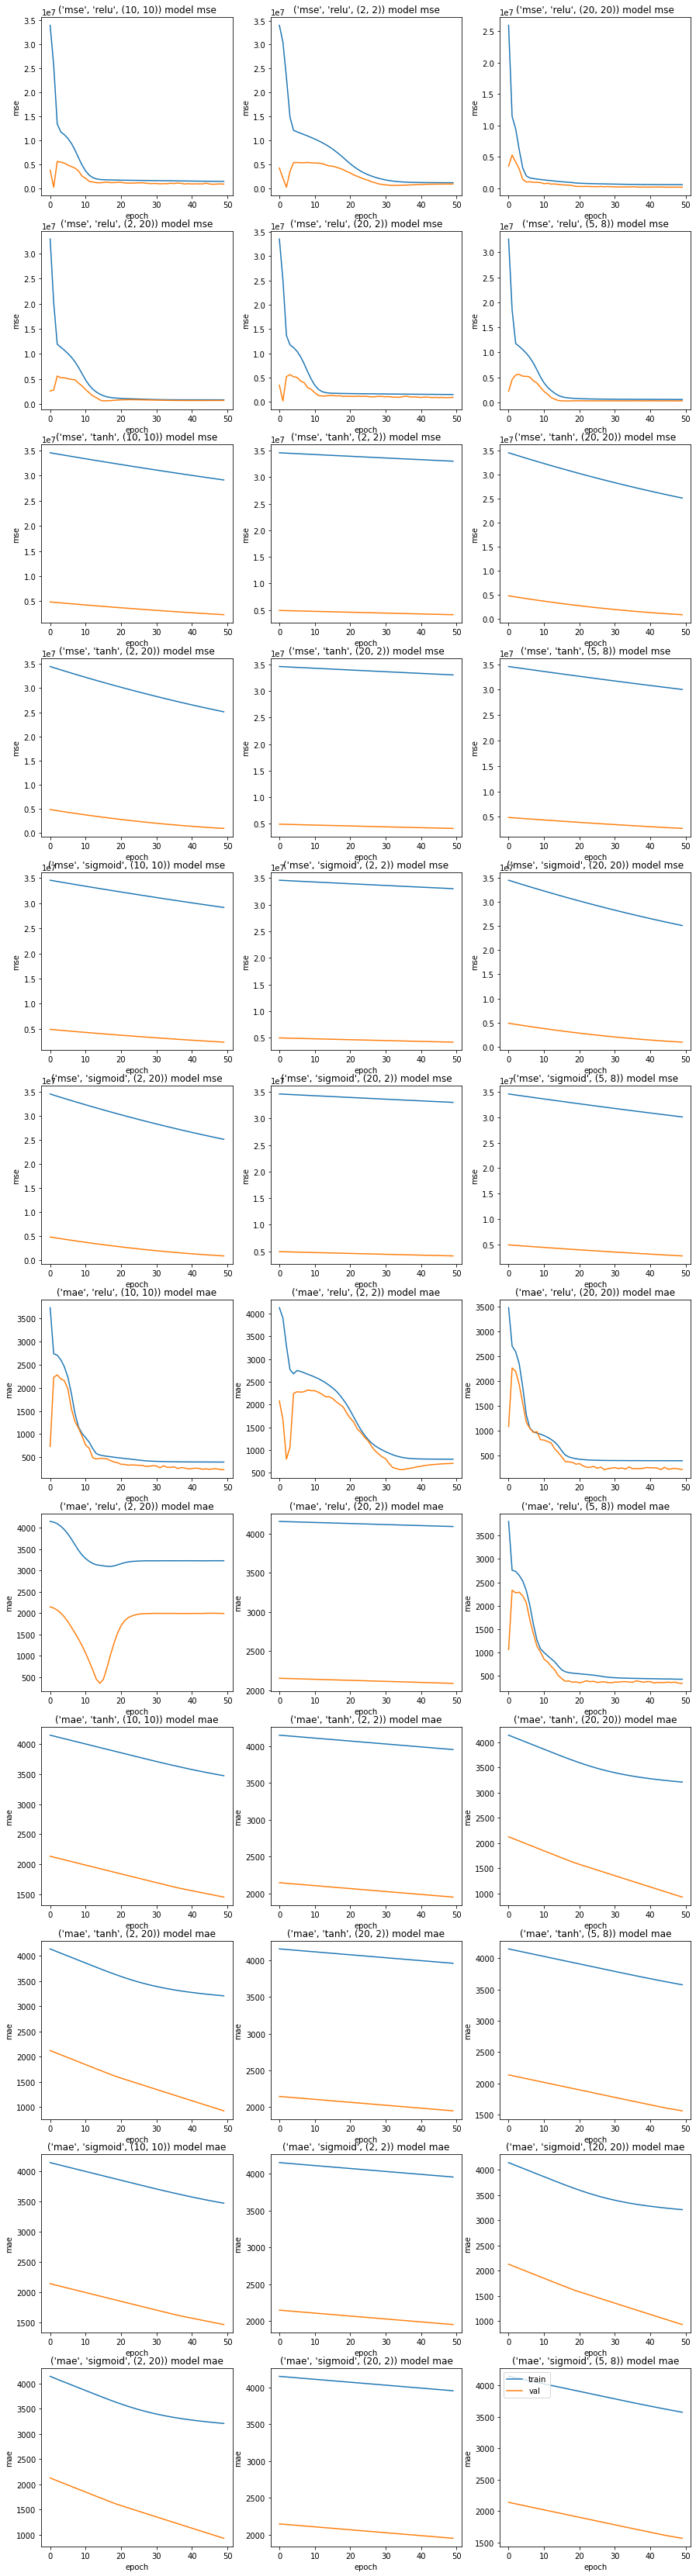

In [110]:
from matplotlib import pyplot as plt

ncols = 3
nrows = len(histories_dict)//ncols + 1 if len(histories_dict) % 3 != 0 else len(histories_dict)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches((15,60))

for i, history in enumerate(histories_dict):
    estimator = history[0]
    axes[i // ncols, i % ncols].plot(histories_dict[history][estimator])
    axes[i // ncols, i % ncols].plot(histories_dict[history][f'val_{estimator}'])
    axes[i // ncols, i % ncols].set_title(f'{history} model {estimator}')
    axes[i // ncols, i % ncols].set_ylabel(estimator)
    axes[i // ncols, i % ncols].set_xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

#### Diagrama del mejor modelo (MSE + MAE)

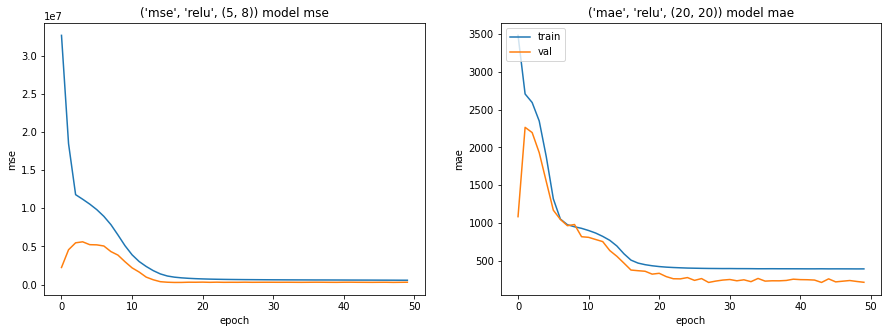

In [112]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((15,5))

history_mse = ('mse', 'relu', (5, 8))
history_mae = ('mae', 'relu', (20, 20))

for i, history in enumerate([history_mse, history_mae ]):
    estimator = history[0]
    axes[i].plot(histories_dict[history][estimator])
    axes[i].plot(histories_dict[history][f'val_{estimator}'])
    axes[i].set_title(f'{history} model {estimator}')
    axes[i].set_ylabel(estimator)
    axes[i].set_xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

De todos los diagramas anteriores, se puede notar que para el caso de las funciones de activación `relu`, que es la que obtiene los mejores resultados, alcanza estabilidad temprano en las epochs. Además, los valores de las métricas se estabilizan en valores muy similares con esta función, llegando a ser casi idénticos en el caso de mse.

Para el caso del resto de las funciones de activación, `sigmoid` y `tanh`, se puede notar en los diagramas que las epochs no fueron suficientes para llegar a un valor estable, pero continúan bajando consistentemente a lo largo del entrenamiento, continuando una tendencia a la baja. Se puede suponer que se podría llegar a un valor estable, tal como sucede con los modelos que usan MAE. Sin embargo, esto requeriría un mayor tiempo de entrenamiento, y cabe notar que mientras más tiempo de entrenamiento se le de al modelo sobre el mismo set de datos, más tendencia habrá al overfitting.

# Pregunta 4

Para esta parte de la actividad, se seleccionan los siguientes hiperparámetros, según el resultado obtenido en la parte anterior:
- Neuronas de capa de entrada: 20
- Neuronas de capa intermedia: 20
- Función de activación: `relu`

In [133]:
input_layer_n = 20
hidden_layer_n = 20
activation_function = 'relu' 

hidden_layers_range = [2, 5, 8, 10]
neurons_range = (5, 30)

In [134]:
def create_dl_model(tup, input_shape, activation):
    model = Sequential()
    initial_layer_n = tup[0]
    initial_layer = Dense(initial_layer_n, input_shape=input_shape, activation=activation)
    model.add(initial_layer)
    for n in tup[1:]:
        hidden_layer = Dense(n, activation=activation)
        model.add(hidden_layer)
    output_layer = Dense(1)
    model.add(output_layer)
    return model


In [136]:
from random import randint
# Create models
dl_models = {}

for n_hidden_layers in hidden_layers_range:
    for _ in range(4):
        neurons = [input_layer_n, hidden_layer_n]
        for _ in range(n_hidden_layers - 1):
            neurons.append(randint(*neurons_range))
        neurons = tuple(neurons)
        for est in ['mse','mae']:
            print(f"Creating model with estimator {est}, {n_hidden_layers} layers, and neurons {neurons}")
            new_model = create_dl_model((input_layer_n, hidden_layer_n, 20), input_shape, activation_function)
            new_model.compile(loss='mse', optimizer='rmsprop', metrics=est)
            dl_models[est, neurons] = new_model


Creating model with estimator mse, 2 layers, and neurons (20, 20, 12)
Creating model with estimator mae, 2 layers, and neurons (20, 20, 12)
Creating model with estimator mse, 2 layers, and neurons (20, 20, 21)
Creating model with estimator mae, 2 layers, and neurons (20, 20, 21)
Creating model with estimator mse, 2 layers, and neurons (20, 20, 20)
Creating model with estimator mae, 2 layers, and neurons (20, 20, 20)
Creating model with estimator mse, 2 layers, and neurons (20, 20, 16)
Creating model with estimator mae, 2 layers, and neurons (20, 20, 16)
Creating model with estimator mse, 5 layers, and neurons (20, 20, 18, 25, 14, 10)
Creating model with estimator mae, 5 layers, and neurons (20, 20, 18, 25, 14, 10)
Creating model with estimator mse, 5 layers, and neurons (20, 20, 9, 5, 8, 12)
Creating model with estimator mae, 5 layers, and neurons (20, 20, 9, 5, 8, 12)
Creating model with estimator mse, 5 layers, and neurons (20, 20, 30, 16, 6, 7)
Creating model with estimator mae, 5 l

In [137]:
# Fit models
number_of_epochs = 50

dl_histories = {}

for model in dl_models:
    print(f'Training {model} model')
    current_model = dl_models[model]
    history = current_model.fit(X_tov, y_tov, epochs=number_of_epochs, batch_size=32, verbose=0, validation_split=0.11)
    dl_histories[model] = history

Training ('mse', (20, 20, 12)) model
Training ('mae', (20, 20, 12)) model
Training ('mse', (20, 20, 21)) model
Training ('mae', (20, 20, 21)) model
Training ('mse', (20, 20, 20)) model
Training ('mae', (20, 20, 20)) model
Training ('mse', (20, 20, 16)) model
Training ('mae', (20, 20, 16)) model
Training ('mse', (20, 20, 18, 25, 14, 10)) model
Training ('mae', (20, 20, 18, 25, 14, 10)) model
Training ('mse', (20, 20, 9, 5, 8, 12)) model
Training ('mae', (20, 20, 9, 5, 8, 12)) model
Training ('mse', (20, 20, 30, 16, 6, 7)) model
Training ('mae', (20, 20, 30, 16, 6, 7)) model
Training ('mse', (20, 20, 6, 18, 14, 12)) model
Training ('mae', (20, 20, 6, 18, 14, 12)) model
Training ('mse', (20, 20, 6, 27, 22, 10, 23, 27, 10)) model
Training ('mae', (20, 20, 6, 27, 22, 10, 23, 27, 10)) model
Training ('mse', (20, 20, 12, 12, 16, 19, 19, 20, 22)) model
Training ('mae', (20, 20, 12, 12, 16, 19, 19, 20, 22)) model
Training ('mse', (20, 20, 22, 15, 12, 5, 24, 6, 13)) model
Training ('mae', (20, 2

In [138]:
import pickle
# Save trained models
for model in dl_models:
    dl_models[model].save(f'models/p4/{model}')

dl_histories_dict = {model : dl_histories[model].history for model in dl_histories}

# Save history
with open('models/p4/history', 'wb') as history_file:
    pickle.dump(dl_histories_dict, history_file)

INFO:tensorflow:Assets written to: models/p4/('mse', (20, 20, 12))/assets
INFO:tensorflow:Assets written to: models/p4/('mae', (20, 20, 12))/assets
INFO:tensorflow:Assets written to: models/p4/('mse', (20, 20, 21))/assets
INFO:tensorflow:Assets written to: models/p4/('mae', (20, 20, 21))/assets
INFO:tensorflow:Assets written to: models/p4/('mse', (20, 20, 20))/assets
INFO:tensorflow:Assets written to: models/p4/('mae', (20, 20, 20))/assets
INFO:tensorflow:Assets written to: models/p4/('mse', (20, 20, 16))/assets
INFO:tensorflow:Assets written to: models/p4/('mae', (20, 20, 16))/assets
INFO:tensorflow:Assets written to: models/p4/('mse', (20, 20, 18, 25, 14, 10))/assets
INFO:tensorflow:Assets written to: models/p4/('mae', (20, 20, 18, 25, 14, 10))/assets
INFO:tensorflow:Assets written to: models/p4/('mse', (20, 20, 9, 5, 8, 12))/assets
INFO:tensorflow:Assets written to: models/p4/('mae', (20, 20, 9, 5, 8, 12))/assets
INFO:tensorflow:Assets written to: models/p4/('mse', (20, 20, 30, 16, 

In [ ]:
# Load models
dl_models = {}

for est in estimators:
    for act in activation_functions:
        for tup in tuples:
            new_model = keras.models.load_model(f'models/p4/{(est, act, tup)}')
            dl_models[(est, act, tup)] = (new_model)

dl_histories_dict = {}

# Load history
with open('models/p4/history', 'rb') as history_file:
    dl_histories_dict = pickle.load(history_file)

## Test results

In [139]:
dl_results = {}

for model in dl_models:
    print(f'Evaluating {model}')
    dl_results[model] = dl_models[model].evaluate(X_test, y_test, verbose=1)

Evaluating ('mse', (20, 20, 12))
168/168 [==============================] - 0s 719us/step - loss: 449046.5000 - mse: 449046.5000
Evaluating ('mae', (20, 20, 12))
168/168 [==============================] - 0s 811us/step - loss: 346950.0312 - mae: 321.0223
Evaluating ('mse', (20, 20, 21))
168/168 [==============================] - 0s 828us/step - loss: 332581.2500 - mse: 332581.2500
Evaluating ('mae', (20, 20, 21))
168/168 [==============================] - 0s 735us/step - loss: 423676.9375 - mae: 349.5192
Evaluating ('mse', (20, 20, 20))
168/168 [==============================] - 0s 677us/step - loss: 361926.9688 - mse: 361926.9688
Evaluating ('mae', (20, 20, 20))
168/168 [==============================] - 0s 748us/step - loss: 417358.9688 - mae: 365.7992
Evaluating ('mse', (20, 20, 16))
168/168 [==============================] - 0s 666us/step - loss: 329618.2500 - mse: 329618.2500
Evaluating ('mae', (20, 20, 16))
168/168 [==============================] - 0s 533us/step - loss: 381090.8

Se usaron parámetros similares a la parte 3, con batches de 32 de largo y 50 epochs. Se usó también la cantidad de nodos para la primera y segunda capa y la función de activación encontradas en el mejor modelo de la parte 3. En esta parte, además de lo anterior, se agregaron más capas intermedias, variando la cantidad de estas capas, y la cantidad de neuronas que cada una contiene.

A continuación, se muestra una tabla con el resultado del testeo y las métricas correspondientes (nota, en las capas se consideran las iniciales y la intermedia de la p3, ambas al inicio y con 20 neuronas).

### TABLA

| Layers \ Metric                                  |         MSE |      MAE |
|--------------------------------------------------|------------:|---------:|
| 3 - (20, 20, 12)                                 | 449046.5000 | 321.0223 |
| 3 - (20, 20, 21)                                 | 332581.2500 | 349.5192 |
| 3 - (20, 20, 20)                                 | 361926.9688 | 365.7992 |
| 3 - (20, 20, 16)                                 | 329618.2500 | 324.6467 |
| 6 - (20, 20, 18, 25, 14, 10)                     | 358084.5938 | 327.0623 |
| 6 - (20, 20, 9, 5, 8, 12)                        | 396397.7812 | 309.8640 |
| 6 - (20, 20, 30, 16, 6, 7)                       | 380457.4375 | 320.0869 |
| 6 - (20, 20, 6, 18, 14, 12)                      | 379022.9688 | 334.0429 |
| 9 - (20, 20, 6, 27, 22, 10, 23, 27, 10)          | 362904.7188 | 309.3775 |
| 9 - (20, 20, 12, 12, 16, 19, 19, 20, 22)         | 325354.2188 | 370.5172 |
| 9 - (20, 20, 22, 15, 12, 5, 24, 6, 13)           | 364881.7188 | 325.4764 |
| 9 - (20, 20, 29, 26, 13, 18, 12, 9, 11)          | 339221.0312 | 329.2669 |
| 11 - (20, 20, 14, 5, 24, 13, 18, 20, 5, 13, 20)  | 356284.3125 | 328.3558 |
| 11 - (20, 20, 29, 11, 18, 18, 29, 13, 14, 5, 30) | 445988.8125 | 354.5894 |
| 11 - (20, 20, 5, 17, 10, 17, 12, 10, 29, 26, 26) | 373874.3750 | 334.3658 |
| 11 - (20, 20, 23, 16, 8, 25, 5, 28, 25, 18, 20)  | 390414.2188 | 328.1975 |


Se puede ver que comparado a los modelos de la parte anterior, todos los modelos entrenados aquí lograron puntajes relativamente buenos en ámbas métricas.

El modelo con el mejor MAE (309.8640) fue aquel con 9 capas, y la siguiente distribución de neuronas por capa: (20, 20, 6, 27, 22, 10, 23, 27, 10), más una extra de salida. A diferencia de los modelos con la misma cantidad de capas, esta varía distribuídamente entre capas con un cantidad de neuronas mayor y menor a 20, mientras que el resto se mantienenpor debajo o cercano a 20.

El modelo entrenado en esta parte, supera al mejor modelo encontrado en la parte anterior, el cual tuvo un MAE de 373. Cabe destacar también, que todos los modelos entrenados en esta parte tuvieron un mejor desempeño que el mejor de la parte 3, por lo que se podría decir con bastante seguridad que este problema se beneficia de redes neuronales profundas.


## Gráficos de evolución de las métricas

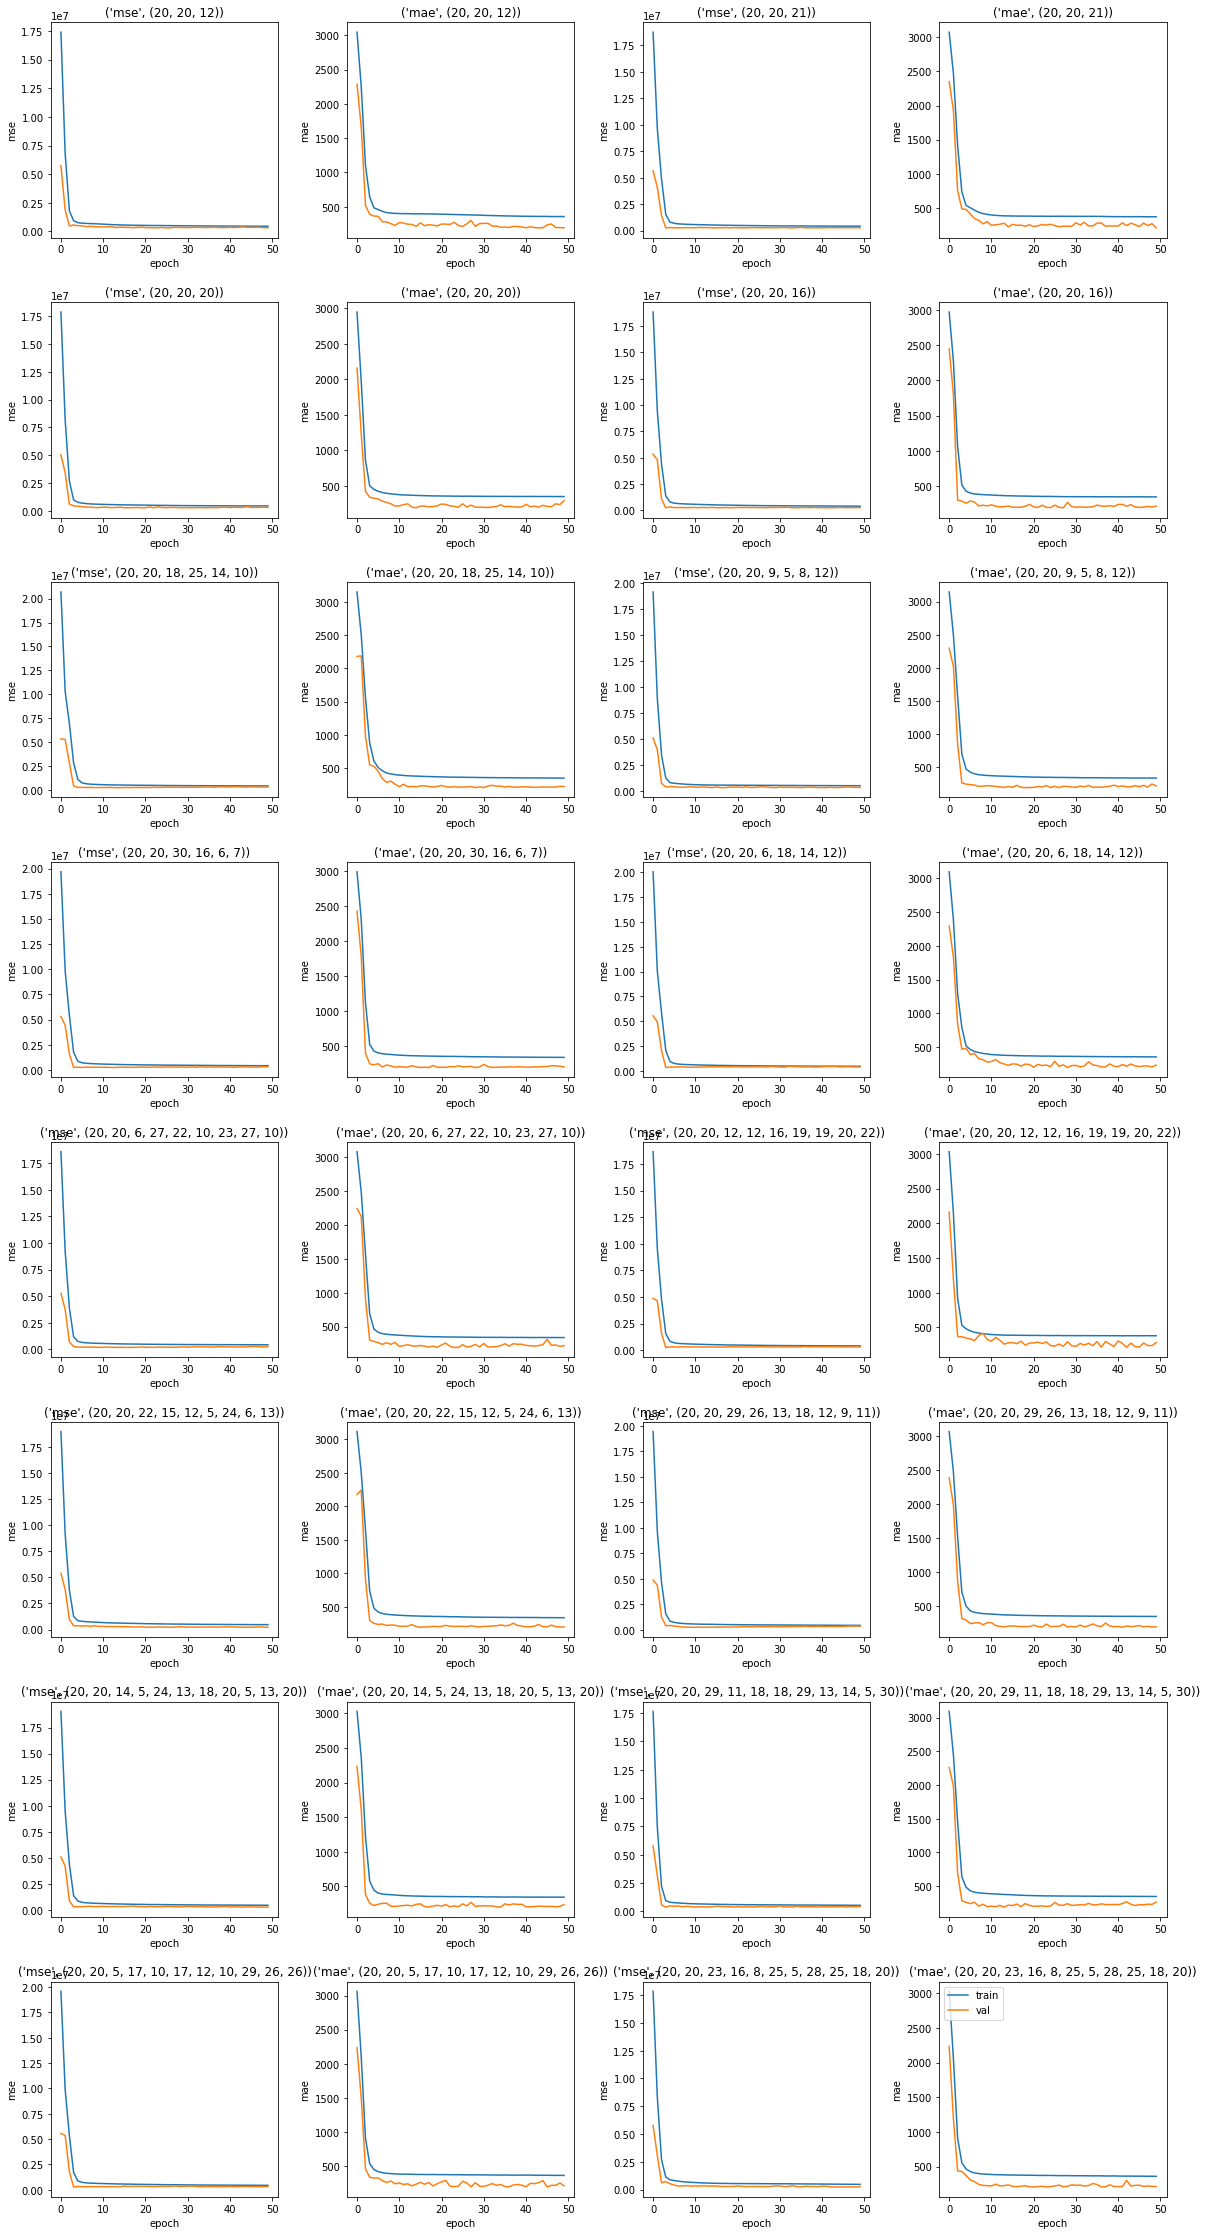

In [152]:
from matplotlib import pyplot as plt

ncols = 4
nrows = len(dl_histories_dict)//ncols + 1 if len(dl_histories_dict) % ncols != 0 else len(dl_histories_dict)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches((20, 40))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i, history in enumerate(dl_histories_dict):
    estimator = history[0]
    axes[i // ncols, i % ncols].plot(dl_histories_dict[history][estimator])
    axes[i // ncols, i % ncols].plot(dl_histories_dict[history][f'val_{estimator}'])
    axes[i // ncols, i % ncols].set_title(f'{history}')
    axes[i // ncols, i % ncols].set_ylabel(estimator)
    axes[i // ncols, i % ncols].set_xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

#### Gráfico mejor modelo

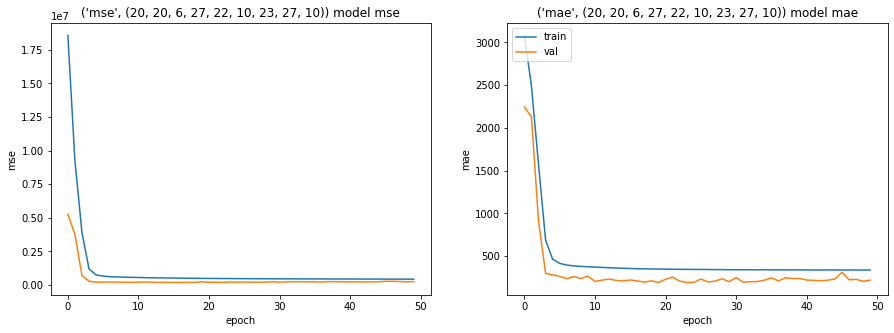

In [162]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((15,5))

history_mse = ('mse', (20, 20, 6, 27, 22, 10, 23, 27, 10))
history_mae = ('mae', (20, 20, 6, 27, 22, 10, 23, 27, 10))

for i, history in enumerate([history_mse, history_mae]):
    estimator = history[0]
    axes[i].plot(dl_histories_dict[history][estimator])
    axes[i].plot(dl_histories_dict[history][f'val_{estimator}'])
    axes[i].set_title(f'{history} model {estimator}')
    axes[i].set_ylabel(estimator)
    axes[i].set_xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

A partir de los gráficos anteriores, se puede ver que ambas métricas convergen a valores más estables mucho más temprano que los modelos de la parte 3, llegando ahora a un valor aproximadamente estable generalmente antes de las 5 epochs.

### Predictions

In [166]:
best_p3_predict = models[('mae', 'relu', (20, 20))].predict(X_test)
best_p4_predict = dl_models[('mae', (20, 20, 6, 27, 22, 10, 23, 27, 10))].predict(X_test)

y_test

array([ 326,  337,  337, ..., 2756, 2756, 2757])

#### Real vs predicted (P3 y P4)

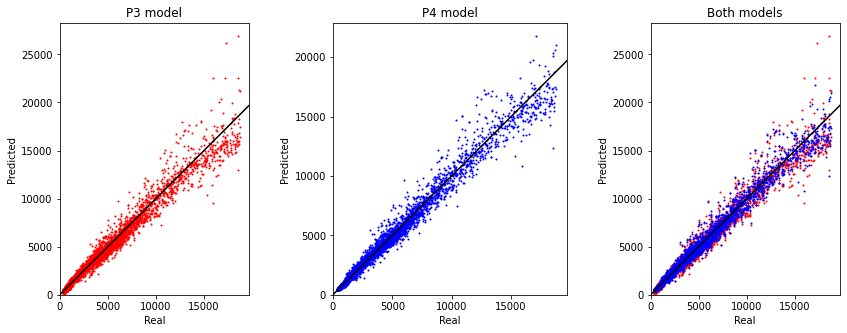

In [215]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches((15,5))


axes[0].scatter(y_test, best_p3_predict, s=1, color='red')
axes[0].set_title('P3 model')
axes[1].scatter(y_test, best_p4_predict, s=1, color='blue')
axes[1].set_title('P4 model')


axes[2].set_title('Both models')
axes[2].scatter(y_test, best_p3_predict, s=1, color='red')
axes[2].scatter(y_test, best_p4_predict, s=1, color='blue')

x = np.linspace(0,25000,100)
y = x

for i in range(3):
    axes[i].set_xlabel('Real value')
    axes[i].set_ylabel('Predicted value')
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].set_ylim(ymin=0)
    axes[i].set_xlim(xmin=0)
    axes[i].set_ylabel('Predicted')
    axes[i].set_xlabel('Real')
    axes[i].plot(x, y, color='black')

Para estos gráficos, mientras más comprimidos estén los puntos en el eje $x = y$, mejor es el modelo. Una línea recta correspondería a un modelo perfecto (como se muestra en negro en los gráficos)

En los gráficos anteriores, que ambos modelos tienen sus valores predichos bastante cercanos al eje $x = y$. Sin embargo, en el caso del modelo más profundo, se puede notar que los datos se encuentran más comprimidos. También, el modelo de la parte 4 genera menos "outliers" (datos que están mal predichos por un margen significativo) que el 3. Se puede notar que hay puntos rojos que se encuentran bastante separados de la línea central, mientras que los azules tienden a estar más cerca de la línea central.

### Linear Regression

In [222]:
from sklearn.metrics import r2_score

print("R2 Modelo P3:", r2_score(y_test, best_p3_predict))
print("R2 Modelo P4:", r2_score(y_test, best_p4_predict))



R2 Modelo P3: 0.9709499408628021
R2 Modelo P4: 0.9800681020311494


El modelo más profundo tiene un valor $R^2$ levemente más alto que el modelo de la P3, lo que indica que los datos predecidos por el modelo P4 se ajustan más a los datos reales del set de test, que el modelo P3, aunque por un margen bien pequeño.

**¿Por qué el modelo más profundo (parte 4) es mejor que el primero (parte 3)?**

La parte 4 resulta en un modelo mejor, debido a que se puede manejar mejor la matriz de características y la cantidad de variables específicas para este problema. En general, si un set de datos tiene bastantes características, el ocupar varias layers permite que cada capa distinta se concentre en procesar y reconocer un subset específico de las características del programa, complementandose con el resto de las capas del modelo, para poder formar una red que logre predecir de manera más acertada. Esto podría compararse al caso de los árboles de decisión, donde el objetivo de cada nivel es reducir la entropía en la mayor medida posible, diferenciando características específicas en cada nivel. Para el caso del modelo de la parte 3, este sólo fue formado con 3 capas, la de input, una intermedia, y una de output, por lo cual, se le hace más difícil al modelo concentrar el reconocimiento de ciertas características en neuronas específicas, y deben tomarse todas en cuenta dentro de un mismo nivel.

El caso de los diamantes podría de alguna manera compararse al ejemplo de reconocimiento facial discutido en clases. Cuando queremos entrenar modelos para datos con bastantes características, en general, un modelo más profundo y con más capas, permitirá una mejor predicción y un mejor manejo de cada característica.

Dicho todo lo anterior, también hay que tener en cuenta que agregar más capas a un modelo no necesariamente resulta en una mejora en la predicción. Llega un punto en el entrenamiento en que tener una cantidad de capas provoca un sobreajuste/overfitting a los datos de training, lo que provocará un peor desempeño al evaluar con el set de validación, dificultando el aprendizaje y resultando en modelos menos precisos.


# Problema de Aprendizaje Reforzado

#AR - demo

In [ ]:
#Descarga del ambiente (RUN ME!)
%%bash
pip install gym pyvirtualdisplay > /dev/null 2>&1
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
apt-get update > /dev/null 2>&1
apt-get install cmake > /dev/null 2>&1
pip install --upgrade setuptools 2>&1
pip install ez_setup > /dev/null 2>&1
pip install gym[atari] > /dev/null 2>&1
pip3 install box2d-py

In [ ]:
#@title Importes (RUN ME TOO!)
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Vamos a inicializar el ambiente

In [ ]:
env = gym.make('CartPole-v1')

Cada vez que se resetea el ambiente se envía una observación del estado en el que inicia la nueva instancia.

In [ ]:
obs = env.reset()
print(obs)

Estos son los estados de ciertas variables importantes, para el ambiente. En ese caso estamos utilizando el ambiente ```CartPole-v1```. Según la [wiki](https://github.com/openai/gym/wiki/CartPole-v0) del toolkit las observaciones del sistema son: <p>

>Num | Observations | Min | Max
>--- | --- | ---  | ---
>0 | Cart Position | -2.4 | 2.4
>1 | Cart Velocity | -Inf | Inf
>2 | Pole Angle | ~-41.8° | ~41.8°
>3 | Pole Velocity at tip | -Inf | Inf


In [ ]:
print('Su espacio de acciones es', env.action_space)

En pocas palabras

>Num | Action
>--- | --- 
>0 | Push car to left
>1 | Push car to right

Cada vez que se carga el ambiente se inicializa en algún estado aleatorio, con el péndulo en posición vertical. Veamos dos ejemplos.

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'));

In [ ]:
env.reset()
plt.imshow(env.render(mode='rgb_array'));

La diferencia es sutil, esto pues este ambiente tiene un desafío como diseño. Hay que mantener el péndulo vertical tanto como se pueda. Luego de eso el ambiente termina. <br>
Ambientes como éste se denominan episódicos. Y tienden a funcionar en series de episodios. Muchos juegos caen en esta categoría, juegos de atari como pacman, o incluso juegos analógicos como el ajedrés también son episódicos.<br>
Los episodios de este ambiente terminan si:


*   El ángulo del péndulo es mayor a $\pm 12°$
*   La posición del carro es mayor a $\pm 2.4$
*   El largo del episodio es mayor a 500



Cada ambiente puede enviar una secuencia de acciones aleatorias si se le desea.

In [ ]:
[env.action_space.sample() for _ in range(10)]

Calculemos cuantas acciones de "ir a la izquierda" puede tomar en promedio el sistema antes de que termine el episodio.

In [ ]:
def actions_till_done(env, action):
    env.reset()
    done = False
    count = 0
    while done == False:
        _, _, done, _, = env.step(action)
        count += 1
    return count
  
# Get an estimate for how many 0 actions you can take on average before the 
# pole falls over
np.mean([actions_till_done(env, 0) for _ in range(100)])

De la misma manera se puede definir un criterio que calcule la cantidad de recompensas que se pueden obtener por episodio en promedio.

In [ ]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=500):
    episode_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        episode_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(episode_rewards), 
        "StandardDeviation":np.sqrt(np.var(episode_rewards))
    }

In [ ]:
def agent_left(observation):
    return {"Action":0}

In [ ]:
average_episodic_return(env, agent_left)

De la misma forma que pudimos mostrar una imagen de un estado del agente se puede presentar al agente en una secuencia animada.

In [ ]:
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

¿Cómo se ve el agente cuando se le da la orden de ir siempre a la izquierda?

In [ ]:
def agent_left(observation):
    return {"Action":0}
  
animate_agent(env, agent_left, max_steps = 400)

¿Y si se envía una orden aleatoria para que se mueva a izquierda o derecha?

In [ ]:
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

In [ ]:
average_episodic_return(env, agent_random)

In [ ]:
animate_agent(env, agent_random)

Podemos definir una función que discretice el valor del estado en caso de que necesitasemos un valor en este dominio.

In [ ]:
def state_for(observation):
    ranges = [np.arange(-1, 1.25, 0.25), np.arange(-0.3, 0.375, 0.075)[:9], np.arange(-1, 1.25, 0.25)]
    state = np.zeros((3,)) #Ignorando el primer sensor
    for i, (obs, limits) in enumerate(zip(observation[1:], ranges)):
        if obs < limits[0]:
            state[i] = 0
            continue
        for j in range(1, len(limits) - 1):
            if limits[j] <= obs <= limits[j+1]:
                state[i] = j
                break
        if obs > limits[len(limits) - 1]:  
            state[i] = len(limits)

    currstate = 0

    for i in range(3): 
        currstate += state[i] * (10 ** i)

    return int(currstate)


Este es un ejemplo del carro cuando ha sido entrenado correctamente un agente utilizando q learning.

In [ ]:
animate_agent(env, agent)

In [ ]:
average_episodic_return(env, agent)

#Pregunta 5

In [ ]:
env = gym.make('Pendulum-v0')

#Pregunta 6

#Pregunta 7 (BONO)